# P4 - Anticipez les besoins en consommation électrique de bâtiments

# Partie 2 - modèles de prédictions


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set()
plt.style.use('seaborn-whitegrid')

In [2]:
data = pd.read_csv("data.csv", index_col=0)
print(data.shape)

(1683, 62)


## Imports et fonctions

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

from time import time
from pprint import pprint

from sklearn.linear_model import LinearRegression, Ridge,Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import GridSearchCV

In [4]:
def transform_dataset(X, y, numeric_features, categorical_features):
    ''' Fonction de préprocessing '''
    X = pd.get_dummies(X, columns=categorical_features)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X, X_train, X_test, y_train, y_test


def transform_dataset_drop_cols(X, y, numeric_features, categorical_features, cols_to_drop):
    ''' Fonction de préprocessing utilisée après sélection
    des variables pour tester le modèle en supprimant des 
    variables catégorielles de valeur définie. '''
    X = pd.get_dummies(X, columns=categorical_features)
    X = X.drop(columns=cols_to_drop)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X, X_train, X_test, y_train, y_test


def run_model(X_train, X_test, y_train, y_test, model, model_name, train_time=0, log=False):
    ''' Fonction qui lance un modèle de machine learning 
    et retourne un dataset avec les différentes métriques.
    Si log=True on considère que la variable cible a 
    été passée au log lors du preprocessing. '''
    try:
        print('Paramètres du modèle', model_name, ':')
        pprint(model.get_params())
    except:
        pass
    
    if train_time == 0:
        start = time()
        model.fit(X_train, y_train)
        train_time = time() - start   
    
    start = time()
    pred_train = model.predict(X_train)
    predict_time_train = time()-start
    
    start = time()
    pred_test = model.predict(X_test)
    predict_time_test = time()-start  

    R2_train = model.score(X_train,y_train)
    
    if log == True:
        y_train, y_test, pred_train, pred_test =  np.expm1(y_train), np.expm1(y_test), np.expm1(pred_train), np.expm1(pred_test)

    RMSE_train = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
    R2_test = r2_score(y_test,pred_test)
    RMSE_test = np.sqrt(metrics.mean_squared_error(y_test,pred_test))  
    
    data = {'training_time': train_time, 'R2_train': R2_train,
            'RMSE_train': RMSE_train, 'predict_time_train': predict_time_train, 'R2_test': R2_test,
            'RMSE_test': RMSE_test, 'predict_time_test':predict_time_test}
    
    return pd.DataFrame(data, index = [model_name])


def test_models(X_train, X_test, y_train, y_test):
    ''' Fonction pour tester différents modèles
    avec paramètres par défaut. '''
    
    regressors = [
        GradientBoostingRegressor(),
        RandomForestRegressor(),
        LinearRegression(),
        Lasso(tol=0.05),
        Ridge(),
        ElasticNet(),
        DummyRegressor(strategy='mean'),
    ]

    test_models = pd.DataFrame()

    for model in regressors:
        test_models = pd.concat([test_models, run_model(X_train, X_test, y_train, y_test, model, str(model))])

    return test_models.sort_values(by='R2_test', ascending=False)

## Prédictions de la consommation d'énergie
### Test des modèles avec paramètres par défaut

In [5]:
data_X = data.drop(columns=['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)', # variables cibles
                                   'SourceEUIWN(kBtu/sf)', 'ENERGYSTARScore', # utilisées lors du test avec l'ESS
                                   'Outlier_bool', # moins efficace que 'Outlier'
                                   'Electricity_ratio', 'Steam_ratio', 'NaturalGas_ratio', 'OtherEnergy_ratio' 
                                   # fuite de données si on utilise les ratios (et n'améliore pas le modèle après test)
                                  ]).fillna(0).copy(deep=True)

numeric_features = ['building_age','PropertyGFATotal','PropertyGFAParking', 'PropertyGFABuilding(s)',
                    'NumberofFloors', 'NumberofBuildings', 'Latitude', 'Longitude'] + \
                    [col for col in data_X.columns if col.startswith('Type_')]

categorical_features = ['PrimaryPropertyType', 'Neighborhood', 'CouncilDistrictCode', 'Primary_energy_source',
                        'Secondary_energy_source','Outlier','BuildingType','Electricity', 'Steam', 'NaturalGas',
                        'OtherEnergy']

X = data_X.copy(deep=True)
y = data['SiteEnergyUse(kBtu)']

In [6]:
X, X_train, X_test, y_train, y_test = transform_dataset(X, y, numeric_features, categorical_features)

In [7]:
test_models(X_train, X_test, y_train, y_test)

Paramètres du modèle GradientBoostingRegressor() :
{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}
Paramètres du modèle RandomForestRegressor() :
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,


,training_time,R2_train,RMSE_train,predict_time_train,R2_test,RMSE_test,predict_time_test
RandomForestRegressor(),4.909191,0.911067,9.839574e+06,0.067793,0.810054,6.960892e+06,0.037492
LinearRegression(),0.076294,0.964092,6.252329e+06,0.004745,0.745868,8.051552e+06,0.001050
Ridge(),0.017442,0.964016,6.258949e+06,0.000000,0.744744,8.069339e+06,0.000000
ElasticNet(),0.032614,0.916070,9.558785e+06,0.000000,0.634163,9.660380e+06,0.000000
GradientBoostingRegressor(),1.066271,0.988344,3.562132e+06,0.004001,0.593770,1.017973e+07,0.000000
Lasso(tol=0.05),0.011585,0.949868,7.387590e+06,0.000000,0.461921,1.171583e+07,0.000000
DummyRegressor(),0.000000,0.000000,3.299472e+07,0.000000,-0.002439,1.599113e+07,0.000000


### RandomForestRegressor - optimisation

In [8]:
test_metrics = run_model(X_train, X_test, y_train, y_test, RandomForestRegressor(random_state=4), 'RFR base')
test_metrics

Paramètres du modèle RFR base :
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 4,
 'verbose': 0,
 'warm_start': False}


,training_time,R2_train,RMSE_train,predict_time_train,R2_test,RMSE_test,predict_time_test
RFR base,5.009447,0.917106,9.499631e+06,0.072234,0.828206,6.619943e+06,0.025192


#### Sélection des variables manuelle

In [9]:
data_RFR = data_X.drop(columns=['PropertyGFATotal', 'NumberofBuildings', 'Neighborhood', 'CouncilDistrictCode',
                         'Latitude', 'Longitude', 'Electricity', 'Steam', 'NaturalGas', 'OtherEnergy',  
                         'Secondary_energy_source']).copy(deep=True)

numeric_features = ['building_age', 'PropertyGFABuilding(s)', 'PropertyGFAParking', 'NumberofFloors'] + \
                   [col for col in data_X.columns if col.startswith('Type_')]

categorical_features = ['PrimaryPropertyType',  'Primary_energy_source', 'Outlier','BuildingType']

X = data_RFR.copy(deep=True)
y = data['SiteEnergyUse(kBtu)']

X, X_train, X_test, y_train, y_test = transform_dataset(X, y, numeric_features, categorical_features)

test_metrics = pd.concat([test_metrics, run_model(X_train, X_test, y_train, y_test,
                                                  RandomForestRegressor(random_state=4),'RFR selected feats')])
test_metrics

Paramètres du modèle RFR selected feats :
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 4,
 'verbose': 0,
 'warm_start': False}


,training_time,R2_train,RMSE_train,predict_time_train,R2_test,RMSE_test,predict_time_test
RFR base,5.009447,0.917106,9.499631e+06,0.072234,0.828206,6.619943e+06,0.025192
RFR selected feats,3.049737,0.920901,9.279586e+06,0.069669,0.856973,6.040302e+06,0.030651


#### Sélection des variables grâce à feature_importances_

In [10]:
rfr = RandomForestRegressor(random_state=4)
run_model(X_train, X_test, y_train, y_test, rfr, 'RFR feats')

Paramètres du modèle RFR feats :
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 4,
 'verbose': 0,
 'warm_start': False}


,training_time,R2_train,RMSE_train,predict_time_train,R2_test,RMSE_test,predict_time_test
RFR feats,2.764308,0.920901,9.279586e+06,0.064024,0.856973,6.040302e+06,0.028458


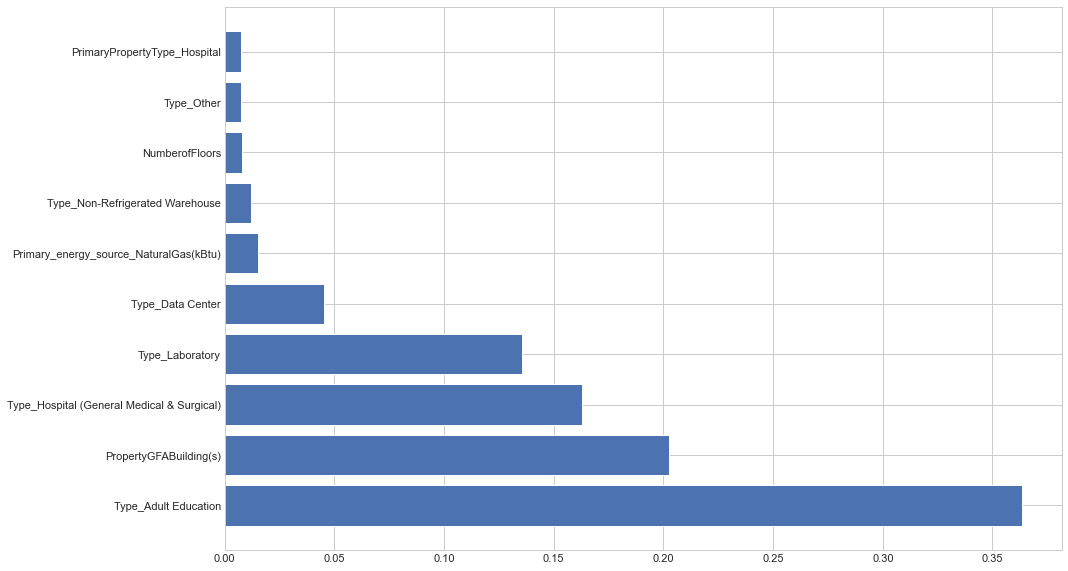

In [11]:
feat_importance = pd.DataFrame({'columns': X.columns, 'feat_importance': rfr.feature_importances_})
feat_importance = feat_importance.sort_values(by='feat_importance', ascending=False)
fig = plt.figure(figsize=(15,10))
plt.barh(feat_importance['columns'][:10], feat_importance['feat_importance'][:10]);

In [12]:
cols_to_drop = feat_importance[feat_importance['feat_importance'] < 1*10**-5]['columns'].tolist()
cols_to_drop

['Type_Social/Meeting Hall',
 'Type_Worship Facility',
 'BuildingType_SPS-District K-12',
 'Type_Automobile Dealership',
 'PrimaryPropertyType_Worship Facility',
 'Type_Pre-school/Daycare',
 'Primary_energy_source_OtherFuelUse(kBtu)',
 'PrimaryPropertyType_Low-Rise Multifamily',
 'BuildingType_Nonresidential WA',
 'PrimaryPropertyType_Office']

In [14]:
X = data_RFR.copy(deep=True)
y = data['SiteEnergyUse(kBtu)']

X, X_train, X_test, y_train, y_test = transform_dataset_drop_cols(X, y, numeric_features, categorical_features,
                                                                  cols_to_drop)

test_metrics = pd.concat([test_metrics, run_model(X_train, X_test, y_train, y_test,
                                                  RandomForestRegressor(random_state=4),'RFR feats_imptce')])
test_metrics

Paramètres du modèle RFR feats_imptce :
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 4,
 'verbose': 0,
 'warm_start': False}


,training_time,R2_train,RMSE_train,predict_time_train,R2_test,RMSE_test,predict_time_test
RFR base,5.009447,0.917106,9.499631e+06,0.072234,0.828206,6.619943e+06,0.025192
RFR selected feats,3.049737,0.920901,9.279586e+06,0.069669,0.856973,6.040302e+06,0.030651
RFR feats_imptce,2.906728,0.921255,9.258817e+06,0.070212,0.861185,5.950709e+06,0.031002


#### GridSearchCV

In [15]:
param_grid = {
    'max_depth': [None, 10, 20, 40],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [100, 200, 400],
    'random_state': [4],
    'n_jobs' : [-1]
}
X = data_RFR.copy(deep=True)
y = data['SiteEnergyUse(kBtu)']

X, X_train, X_test, y_train, y_test = transform_dataset_drop_cols(X, y, numeric_features, categorical_features,
                                                                  cols_to_drop)


rfr = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rfr, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose=2)
start = time()
grid_search.fit(X_train, y_train)
train_time = time() - start
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_

test_metrics = pd.concat([test_metrics, run_model(X_train, X_test, y_train, y_test,
                                                  best_grid,'RFR gridsearchCV', train_time=train_time)])
test_metrics

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  5.8min finished


{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 4}
Paramètres du modèle RFR gridsearchCV :
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 20,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 4,
 'verbose': 0,
 'warm_start': False}


,training_time,R2_train,RMSE_train,predict_time_train,R2_test,RMSE_test,predict_time_test
RFR base,5.009447,0.917106,9.499631e+06,0.072234,0.828206,6.619943e+06,0.025192
RFR selected feats,3.049737,0.920901,9.279586e+06,0.069669,0.856973,6.040302e+06,0.030651
RFR feats_imptce,2.906728,0.921255,9.258817e+06,0.070212,0.861185,5.950709e+06,0.031002
RFR gridsearchCV,348.385066,0.918762,9.404245e+06,0.047850,0.856869,6.042502e+06,0.037017


## Prédictions des émissions de CO2
### Test des modèles avec paramètres par défaut

In [17]:
numeric_features = ['building_age','PropertyGFATotal','PropertyGFAParking', 'PropertyGFABuilding(s)',
                    'NumberofFloors', 'NumberofBuildings', 'Latitude', 'Longitude'] + \
                    [col for col in data_X.columns if col.startswith('Type_')]

categorical_features = ['PrimaryPropertyType', 'Neighborhood', 'CouncilDistrictCode', 'Primary_energy_source',
                        'Secondary_energy_source','Outlier','BuildingType','Electricity', 'Steam', 'NaturalGas',
                        'OtherEnergy']

X = data_X.copy(deep=True)
y = data['GHGEmissions(MetricTonsCO2e)']

X, X_train, X_test, y_train, y_test = transform_dataset(X, y, numeric_features, categorical_features)
test_models(X_train, X_test, y_train, y_test)

Paramètres du modèle GradientBoostingRegressor() :
{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}
Paramètres du modèle RandomForestRegressor() :
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,


,training_time,R2_train,RMSE_train,predict_time_train,R2_test,RMSE_test,predict_time_test
ElasticNet(),0.000000,0.842185,322.104561,0.000000,0.763788,242.216778,0.004002
RandomForestRegressor(),3.918820,0.913032,239.112679,0.058430,0.728508,259.676286,0.013133
Ridge(),0.004000,0.934885,206.901770,0.000000,0.698733,273.545477,0.000000
GradientBoostingRegressor(),1.039800,0.989561,82.840745,0.005589,0.686351,279.110261,0.001050
LinearRegression(),0.005133,0.935006,206.709832,0.000000,0.684974,279.722182,0.000000
Lasso(tol=0.05),0.004007,0.912975,239.191382,0.000000,0.684297,280.022391,0.000000
DummyRegressor(),0.000227,0.000000,810.817980,0.000000,-0.000239,498.431525,0.000000


### ElasticNet optimisation

In [18]:
test_metrics = run_model(X_train, X_test, y_train, y_test, ElasticNet(random_state=4), 'EN base')
test_metrics

Paramètres du modèle EN base :
{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': 4,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}


,training_time,R2_train,RMSE_train,predict_time_train,R2_test,RMSE_test,predict_time_test
EN base,0.009578,0.842185,322.104561,0.0,0.763788,242.216778,0.000998


#### Test avec les variables sélectionnées pour la consommation d'énergie

In [19]:
numeric_features = ['building_age', 'PropertyGFABuilding(s)', 'PropertyGFAParking', 'NumberofFloors'] + \
                   [col for col in data.columns if col.startswith('Type_')]

categorical_features = ['PrimaryPropertyType',  'Primary_energy_source', 'Outlier','BuildingType']

X = data_RFR.copy(deep=True)
y = data['GHGEmissions(MetricTonsCO2e)']

X, X_train, X_test, y_train, y_test = transform_dataset(X, y, numeric_features, categorical_features)

test_metrics = pd.concat([test_metrics, run_model(X_train, X_test, y_train, y_test,
                                                  ElasticNet(random_state=4),'EN selected feats')])
test_metrics

Paramètres du modèle EN selected feats :
{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': 4,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}


,training_time,R2_train,RMSE_train,predict_time_train,R2_test,RMSE_test,predict_time_test
EN base,0.009578,0.842185,322.104561,0.000000,0.763788,242.216778,0.000998
EN selected feats,0.003240,0.835019,329.336609,0.004421,0.764408,241.898873,0.000000


#### Nouvelle sélection manuelle des variables

In [20]:
data_EN = data_X.drop(columns=['NumberofBuildings', 'NumberofFloors', 'Neighborhood']).copy(deep=True)

numeric_features = ['building_age','PropertyGFATotal','PropertyGFAParking', 'PropertyGFABuilding(s)',
                    'Latitude', 'Longitude'] + \
                    [col for col in data.columns if col.startswith('Type_')]

categorical_features = ['PrimaryPropertyType', 'CouncilDistrictCode', 'Primary_energy_source',
                        'Secondary_energy_source','BuildingType', 'Outlier', 'Electricity',
                        'Steam', 'NaturalGas', 'OtherEnergy']

X = data_EN.fillna(0)
y = data['GHGEmissions(MetricTonsCO2e)']

X, X_train, X_test, y_train, y_test = transform_dataset(X, y, numeric_features, categorical_features)
test_metrics = pd.concat([test_metrics, run_model(X_train, X_test, y_train, y_test, ElasticNet(random_state=4), 'EN new select feats')])
test_metrics

Paramètres du modèle EN new select feats :
{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': 4,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}


,training_time,R2_train,RMSE_train,predict_time_train,R2_test,RMSE_test,predict_time_test
EN base,0.009578,0.842185,322.104561,0.000000,0.763788,242.216778,0.000998
EN selected feats,0.003240,0.835019,329.336609,0.004421,0.764408,241.898873,0.000000
EN new select feats,0.009131,0.839946,324.382315,0.000000,0.776787,235.458187,0.004345


#### GridSearchCV

In [21]:
param_grid = {"tol" : [0.001, 0.01, 0.1, 0.5],
              "alpha": np.arange(0.0, 1.0, 0.01),
              "l1_ratio": np.arange(0.0, 1.0, 0.05)}

en = ElasticNet(random_state=4)
grid_search = GridSearchCV(estimator = en, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose=2)
start = time()
grid_search.fit(X_train, y_train)
train_time = time() - start
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_

test_metrics = pd.concat([test_metrics, run_model(X_train, X_test, y_train, y_test, best_grid,
                                                      'EN gridsearchCV', train_time)])
test_metrics

Fitting 5 folds for each of 8000 candidates, totalling 40000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 1196 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 2328 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 3788 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 9304 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 17736 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 27448 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 38472 tasks      | elapsed:  2.3min


{'alpha': 0.99, 'l1_ratio': 0.6000000000000001, 'tol': 0.5}
Paramètres du modèle EN gridsearchCV :
{'alpha': 0.99,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.6000000000000001,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': 4,
 'selection': 'cyclic',
 'tol': 0.5,
 'warm_start': False}


[Parallel(n_jobs=-1)]: Done 40000 out of 40000 | elapsed:  2.4min finished


,training_time,R2_train,RMSE_train,predict_time_train,R2_test,RMSE_test,predict_time_test
EN base,0.009578,0.842185,322.104561,0.000000,0.763788,242.216778,0.000998
EN selected feats,0.003240,0.835019,329.336609,0.004421,0.764408,241.898873,0.000000
EN new select feats,0.009131,0.839946,324.382315,0.000000,0.776787,235.458187,0.004345
EN gridsearchCV,145.307682,0.864648,298.301432,0.004001,0.770906,238.539670,0.000000


### Evaluation de l'intérêt de l'EnergyStarScore

In [36]:
df = data[(~data['ENERGYSTARScore'].isna()) & (data['SourceEUIWN(kBtu/sf)'] >0)].copy()
print(df.shape)

data_no_ESS = df.drop(columns=['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)', 'SourceEUIWN(kBtu/sf)',
                               'ENERGYSTARScore', 'Outlier_bool', 'Electricity_ratio', 'Steam_ratio', 'NaturalGas_ratio',
                               'OtherEnergy_ratio']).fillna(0).copy(deep=True)

numeric_features = ['building_age','PropertyGFATotal','PropertyGFAParking', 'PropertyGFABuilding(s)',
                    'NumberofFloors', 'NumberofBuildings', 'Latitude', 'Longitude'] + \
                    [col for col in df.columns if col.startswith('Type_')]

categorical_features = ['PrimaryPropertyType', 'Neighborhood', 'CouncilDistrictCode', 'Primary_energy_source',
                        'Secondary_energy_source','Outlier','BuildingType','Electricity', 'Steam', 'NaturalGas',
                        'OtherEnergy']

X = data_no_ESS.copy(deep=True)
y = df['GHGEmissions(MetricTonsCO2e)']

X, X_train, X_test, y_train, y_test = transform_dataset(X, y, numeric_features, categorical_features)
test_ESS = run_model(X_train, X_test, y_train, y_test, ElasticNet(random_state=4), 'ElasticNet sans ESS')

(1137, 62)
Paramètres du modèle ElasticNet sans ESS :
{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': 4,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}


In [37]:
param_grid = {"tol" : [0.001, 0.01, 0.1, 0.5],
              "alpha": np.arange(0.0, 1.0, 0.01),
              "l1_ratio": np.arange(0.0, 1.0, 0.05)}

en = ElasticNet(random_state=4)
grid_search = GridSearchCV(estimator = en, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose=2)
start = time()
grid_search.fit(X_train, y_train)
train_time = time() - start
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_

test_ESS = pd.concat([test_ESS, run_model(X_train, X_test, y_train, y_test, best_grid,
                                                      'EN sans ESS gridsearchCV', train_time)])
test_ESS

Fitting 5 folds for each of 8000 candidates, totalling 40000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 432 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1244 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 4840 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 10680 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 17800 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 26232 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 35944 tasks      | elapsed:  1.5min


{'alpha': 0.99, 'l1_ratio': 0.9500000000000001, 'tol': 0.01}
Paramètres du modèle EN sans ESS gridsearchCV :
{'alpha': 0.99,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.9500000000000001,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': 4,
 'selection': 'cyclic',
 'tol': 0.01,
 'warm_start': False}


[Parallel(n_jobs=-1)]: Done 40000 out of 40000 | elapsed:  1.6min finished


,training_time,R2_train,RMSE_train,predict_time_train,R2_test,RMSE_test,predict_time_test
ElasticNet sans ESS,0.006476,0.879698,278.600360,0.001288,0.860672,310.867326,0.0
EN sans ESS gridsearchCV,97.899080,0.960882,158.866001,0.001424,0.945954,193.614103,0.0


In [38]:
data_ESS = df.drop(columns=['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)', 'SourceEUIWN(kBtu/sf)',
                            'Outlier_bool', 'Electricity_ratio', 'Steam_ratio', 'NaturalGas_ratio',
                            'OtherEnergy_ratio']).fillna(0).copy(deep=True)

numeric_features = ['building_age','PropertyGFATotal','PropertyGFAParking', 'PropertyGFABuilding(s)',
                    'NumberofFloors', 'NumberofBuildings', 'Latitude', 'Longitude', 'ENERGYSTARScore'] + \
                    [col for col in df.columns if col.startswith('Type_')]

X = data_ESS.copy(deep=True)
y = df['GHGEmissions(MetricTonsCO2e)']

X, X_train, X_test, y_train, y_test = transform_dataset(X, y, numeric_features, categorical_features)
test_ESS = pd.concat([test_ESS, run_model(X_train, X_test, y_train, y_test,
                                          ElasticNet(random_state=4), 'ElasticNet avec ESS')])
test_ESS

Paramètres du modèle ElasticNet avec ESS :
{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': 4,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}


,training_time,R2_train,RMSE_train,predict_time_train,R2_test,RMSE_test,predict_time_test
ElasticNet sans ESS,0.006476,0.879698,278.600360,0.001288,0.860672,310.867326,0.0
EN sans ESS gridsearchCV,97.899080,0.960882,158.866001,0.001424,0.945954,193.614103,0.0
ElasticNet avec ESS,0.005359,0.882309,275.559733,0.001009,0.846206,326.606893,0.0


In [39]:
param_grid = {"tol" : [0.001, 0.01, 0.1, 0.5],
              "alpha": np.arange(0.0, 1.0, 0.01),
              "l1_ratio": np.arange(0.0, 1.0, 0.05)}

en = ElasticNet(random_state=4)
grid_search = GridSearchCV(estimator = en, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose=2)
start = time()
grid_search.fit(X_train, y_train)
train_time = time() - start
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_

test_ESS = pd.concat([test_ESS, run_model(X_train, X_test, y_train, y_test, best_grid,
                                                      'EN avec ESS gridsearchCV', train_time)])
test_ESS

Fitting 5 folds for each of 8000 candidates, totalling 40000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 1592 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 6776 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 10336 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 18528 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 28240 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 39264 tasks      | elapsed:  1.6min


{'alpha': 0.99, 'l1_ratio': 0.9500000000000001, 'tol': 0.001}
Paramètres du modèle EN avec ESS gridsearchCV :
{'alpha': 0.99,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.9500000000000001,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': 4,
 'selection': 'cyclic',
 'tol': 0.001,
 'warm_start': False}


[Parallel(n_jobs=-1)]: Done 40000 out of 40000 | elapsed:  1.6min finished


,training_time,R2_train,RMSE_train,predict_time_train,R2_test,RMSE_test,predict_time_test
ElasticNet sans ESS,0.006476,0.879698,278.600360,0.001288,0.860672,310.867326,0.000000
EN sans ESS gridsearchCV,97.899080,0.960882,158.866001,0.001424,0.945954,193.614103,0.000000
ElasticNet avec ESS,0.005359,0.882309,275.559733,0.001009,0.846206,326.606893,0.000000
EN avec ESS gridsearchCV,96.941208,0.962289,155.983684,0.000000,0.927496,224.252316,0.004034


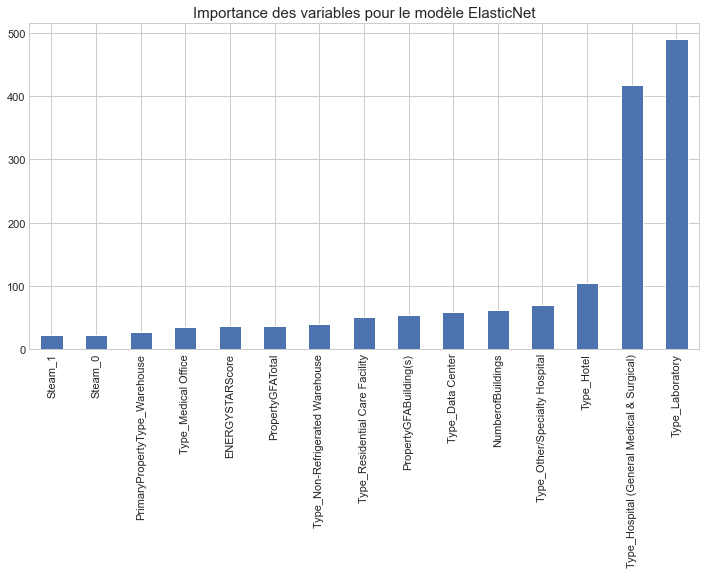

In [40]:
feature_importance = pd.Series(index = X.columns, data = np.abs(best_grid.coef_))
feature_importance.sort_values().tail(15).plot(kind = 'bar', figsize = (12,6))
plt.title('Importance des variables pour le modèle ElasticNet', fontsize=15);